In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
from torch_cka import CKA
from copy import deepcopy
import numpy as np
from torch import nn
import pandas

In [2]:
from torch_cka import CKA
def get_task_mapping(labels, splits):
    task_mapping = []
    for i, label in enumerate(labels):
        for j, split in enumerate(splits):
            if label in split:
                task_mapping.append(j)
    return torch.from_numpy(np.array(task_mapping))

def get_identity_idx(n,m, weight):
    s = min(m,n)
    s = torch.arange(s,device=weight.device)
    return s, s 

@torch.no_grad()
def dummify_model(model:nn.Module):
    for na,m in model.named_modules():
        if len(list(m.parameters(recurse=False)))==0:
            continue
        if isinstance(m,nn.Conv2d):
            m.weight.fill_(0)
            mid_ = m.weight.shape[2]//2
            
            row, col = get_identity_idx(*m.weight.shape[:2],m.weight)
            val = 1 if "shortcut" in na else 0
            m.weight.data[row, col,mid_,mid_] = val
            if m.bias is not None:
                m.bias.fill_(0)
        elif isinstance(m,nn.Linear):
            m.weight.fill_(0)
            row, col = get_identity_idx(*m.weight.shape[:2],m.weight)
            m.weight.data[row, col] = 1
            if m.bias is not None:
                m.bias.fill_(0)
        elif isinstance(m,nn.BatchNorm2d):
            val = 1 if "shortcut" in na else 0
            m.weight.fill_(val)
            m.bias.fill_(0)
            m.running_mean.fill_(0)
            m.running_var.fill_(val)
        else:
            print(f"Not Implement class {m.__class__.__name__}")
            raise NotImplementedError
def align(C):
    """
    Compute the optimal map between hidden layers of two models using dynamic programming.
    
    :param C: cost matrix
    :param start_layer_idx: the layer index to start aligning, default = 2, 
        i.e., start from the second hidden layer
    :param free_end_layers: match last free_end_layers hidden layers 
        of two models, default = 0
    :return: list of layer indices of the large model
    """
    m, n = C.shape
    assert m >= n

    F = torch.zeros((n+1, m+1))

    # compute the diagonal of F
    sum = 0
    for k in range(1, n+1):
        sum += C[k-1, k-1]
        F[k, k] = sum

    # forward recursion
    for k in range(1, n+1):
        for l in range(k+1, m+1):
            F[k, l] = max(F[k, l-1], F[k-1, l-1] + C[l-1, k-1])
    
    # backward recursion 
    A = torch.ones(n+1)
    k, l = n, m
    print(F)
    while (k >= 0):
        while (l >= k+1) and (F[k, l] == F[k, l-1]):
            l -= 1

        A[k] = l
        k -= 1
        l -= 1

    # because the first hidden layer is layer at index 1
    return A[1:]-1

def align2(C):
    """
    Compute the optimal map between hidden layers of two models using dynamic programming.
    
    :param C: cost matrix
    :param start_layer_idx: the layer index to start aligning, default = 2, 
        i.e., start from the second hidden layer
    :param free_end_layers: match last free_end_layers hidden layers 
        of two models, default = 0
    :return: list of layer indices of the large model
    """
    m, n = C.shape
    assert m >= n

    F = torch.zeros((n+1, m+1))

    # compute the diagonal of F
    sum = 0
    for k in range(1, n+1):
        sum += C[k-1, k-1]
        F[k, k] = sum

    # forward recursion
    for k in range(1, n+1):
        for l in range(k+1, m+1):
            print(F)
            F[k, l] = max(F[k, l-1] + C[l-1, k-2], F[k-1, l-1] + C[l-1, k-1])
            # F[k, l] = max(F[k, l-1], F[k-1, l-1] + C[l-1, k-1])
    
    print(F)
    
    # backward recursion 
    A = torch.ones(n+1)
    k, l = n, m
    print(F)
    while (k >= 0):
        while (l >= k+1) and (F[k, l] == F[k, l-1] + C[l-1, k-2]):
            l -= 1

        A[k] = l
        k -= 1
        l -= 1

    #because the first hidden layer is layer at index 1
    return A[1:]-1

def get_matrix(model_a, model_b, dataloader):
    """
    Compute the matrix of pairwise CKA between layers of a model.
    
    :param model: a model
    :param dataloader: a dataloader
    :return: matrix of pairwise CKA
    """
    cka = CKA(model_a, model_b, device = 'cuda', modeltype = 'ResNet')
    matrix = cka.compare(dataloader)
    return matrix

def hetero_align_(a,b, norm_method = "l2"):
    """
    a: 模型a的层间相似性,对于n层的模型,len(a)==n-1
    b: 模型b的层间相似性,对于n层的模型,len(b)==n-1
    """
    n = b.shape[0]
    if norm_method == "zscore":
        a  = (a-a.mean())/a.std()
        b = (b-b.mean())/b.std()
    elif norm_method == "l2":
        a = a / a.norm()
        b = b/ b.norm()
    sim_mat = a.unsqueeze(dim=1) @ b.unsqueeze(dim=0)
    
    print(sim_mat)
    A = align(sim_mat)
    
    res = {str(i+1):str(int(A[i].detach().item())+1) for i in range(n)}
    res[str(n)] = str(a.shape[0])
    return res

def hetero_align(model_a,model_b,train_loader,stages_a,stages_b,norm_method="l2"):
    """
    model_a: 
    model_b:
    train_loader:
    stages_a,stages_b: 模型的不同阶段，输入格式如: [5,5,5],表示模型有3个stages,每个stage包含5个block/layer
    """
    sim_mat_a =  get_matrix(model_a, model_a, train_loader) # 根据model_a,train_loader得到的层相似性矩阵
    sim_mat_b =  get_matrix(model_b, model_b, train_loader)# 根据model_b,train_loader得到的层相似性矩阵
    # print(sim_mat_a)
    # print('---'*10)
    # print(sim_mat_b)

    def sim_mat2diff_seq(sim_mat,stages):
        res = []
        start = 0
        for num_layers in stages:
            diff_seq = torch.empty(num_layers-1)
            print("start",start,"numlayers",num_layers)
            for i in range(num_layers-1):
                diff_seq[i] = sim_mat[start + i,start + i + 1]
            start += num_layers
            res.append(1-diff_seq)
        return res
    
    diff_seqs_a = sim_mat2diff_seq(sim_mat_a,stages_a)
    diff_seqs_b = sim_mat2diff_seq(sim_mat_b,stages_b)
    # print(diff_seqs_a)
    # print('---'*10)
    # print(diff_seqs_b)
    result = []
    for seq_a,seq_b in zip(diff_seqs_a,diff_seqs_b):
        result.append(hetero_align_(seq_a,seq_b,norm_method=norm_method))
    return result


def md_align(model_a,model_b,train_loader,stages_a,stages_b,norm_method="l2"):
    """
    model_a: 
    model_b:
    train_loader:
    stages_a,stages_b: 模型的不同阶段，输入格式如: [5,5,5],表示模型有3个stages,每个stage包含5个block/layer
    """
    sim_mat_a =  get_matrix(model_a, model_a, train_loader) # 根据model_a,train_loader得到的层相似性矩阵
    # sim_mat_b =  get_matrix(model_b, model_b, train_loader)# 根据model_b,train_loader得到的层相似性矩阵
    # print(sim_mat_a)
    # print('---'*10)
    # print(sim_mat_b)

    def sim_mat2diff_seq(sim_mat,stages):
        res = []
        start = 0
        for num_layers in stages:
            diff_seq = torch.empty(num_layers-1)
            print("start",start,"numlayers",num_layers)
            for i in range(num_layers-1):
                diff_seq[i] = sim_mat[start + i,start + i + 1]
            start += num_layers
            res.append(1-diff_seq)
        return res
    
    diff_seqs_a = sim_mat2diff_seq(sim_mat_a,stages_a)
    # diff_seqs_b = sim_mat2diff_seq(sim_mat_b,stages_b)
    # print(diff_seqs_a)
    # print('---'*10)
    # print(diff_seqs_b)
    result = []
    for seq_a, num_layers in zip(diff_seqs_a, stages_b):
        val, idx = torch.topk(seq_a, num_layers-1)
        A = sorted(idx.detach().cpu().tolist())
        res = {str(i+1):str(A[i]+1) for i in range(num_layers-1)}
        res[str(num_layers-1)] = str(a.shape[0])
        result.append(res)
    return result

def homo_align(model_a,model_b,train_loader,stages_a,stages_b):
    """
    model_a: 
    model_b:
    train_loader:
    stages_a,stages_b: 模型的不同阶段，输入格式如: [5,5,5],表示模型有3个stages,每个stage包含5个block/layer
    """
    sim_mat = get_matrix(model_a, model_b, train_loader) # 根据model_a,model_b,train_loader得到的层相似性矩阵

    result = []
    print("shape", sim_mat.shape)
    for num_layer_a,num_layer_b in zip(stages_a,stages_b):
        
        sta,stb = 0,0
        A = align(sim_mat[sta+1:sta+num_layer_a,stb+1:stb+num_layer_b])
        print("sta",sta,"stb",stb,num_layer_a,num_layer_b,"A",A.shape)
        result.append({str(i+1):str(int(A[i].detach().item())+1) for i in range(num_layer_b-1)})
        sta += num_layer_a
        stb += num_layer_b
    return result

def homo2_align(model_a,model_b,train_loader,stages_a,stages_b):
    """
    model_a: 
    model_b:
    train_loader:
    stages_a,stages_b: 模型的不同阶段，输入格式如: [5,5,5],表示模型有3个stages,每个stage包含5个block/layer
    """
    sim_mat = get_matrix(model_a, model_b, train_loader) # 根据model_a,model_b,train_loader得到的层相似性矩阵

    result = []
    print("shape", sim_mat.shape)
    for num_layer_a,num_layer_b in zip(stages_a,stages_b):
        
        sta,stb = 0,0
        A = align2(sim_mat[sta+1:sta+num_layer_a,stb+1:stb+num_layer_b])
        print("sta",sta,"stb",stb,num_layer_a,num_layer_b,"A",A.shape)
        result.append({str(i+1):str(int(A[i].detach().item())+1) for i in range(num_layer_b-1)})
        sta += num_layer_a
        stb += num_layer_b
    return result

def inner_align_(C,n):
    """
    Compute the optimal map between hidden layers of two models using dynamic programming.
    
    :param C: cost matrix
    :param start_layer_idx: the layer index to start aligning, default = 2, 
        i.e., start from the second hidden layer
    :param free_end_layers: match last free_end_layers hidden layers 
        of two models, default = 0
    :return: list of layer indices of the large model
    """
    n -= 1
    m = C.shape[0]
    assert m >= n

    F = torch.zeros((n+1, m+1))
    B = torch.zeros((n+1, m+1))

    # forward recursion
    for k in range(1, n+1):
        for l in range(k+1, m+1):
            for j in range(1, l):
                y = F[k-1, j] + C[j-1,l-1]
                if F[k, l] < y:
                    B[k,l] = j
                    F[k, l] = y
    
    # backward recursion 
    A = torch.ones(n+1)
    maxV, l = 0,0
    print(F)
    for i in range(m+1):
        if F[-1, i] > maxV:
            maxV = F[-1,i]
            A[-1] = B[-1,i]
    for i in range(n-1,-1,-1):
        A[i] = B[i,A[i+1].long()]

    # because the first hidden layer is layer at index 1
    # return F
    return A[1:]
a = torch.tensor([[1,2,3,4,1,4,5,4,1]]).float()
a = a.T @ a
print(a)
inner_align_(a, 2)

def inner_align(model_a,model_b,train_loader,stages_a,stages_b):
    """
    model_a: 
    model_b:
    train_loader:
    stages_a,stages_b: 模型的不同阶段，输入格式如: [5,5,5],表示模型有3个stages,每个stage包含5个block/layer
    """
    sim_mat = get_matrix(model_a, model_a, train_loader) # 根据model_a,model_b,train_loader得到的层相似性矩阵

    result = []
    sta,stb = 0,0
        
    for num_layer_a,num_layer_b in zip(stages_a,stages_b):
        submat = sim_mat[sta:sta+num_layer_a,sta:sta+num_layer_a]
        A = inner_align_(submat, num_layer_b)
        result.append({str(i+1):str(int(A[i].detach().item())+1) for i in range(num_layer_b-1)})
        sta += num_layer_a
        stb += num_layer_b
    return result


def generate_weight_remap(blocks1,blocks2, state_dict2 ,verbose = True,model_a=None,model_b=None,act_loader=None, suffix=""):
    weight_remapping = {}
    layer_map = []
    if "headalign" in suffix:
        return {}
    elif "unialign" in suffix:
        # uniform alignment
        for l1,l2 in zip(blocks1,blocks2):
            skip = int(l1/l2 + 0.5)
            layer_map.append({str(k):str(v) for k,v in zip(range(l2-1,0,-1),range(l1-1,0,-skip))})
    elif "lma" in suffix:
        layer_map = homo2_align(model_a,model_b,act_loader,blocks1,blocks2)
    elif "sma" in suffix:
        layer_map = homo_align(model_a,model_b,act_loader,blocks1,blocks2)
    else:
        return None
    if verbose:
        print("Layer Mapping", layer_map)
    for k,_ in state_dict2.items():
        if k[:len("layer")] != "layer":
            continue
        ks = k.split(".")
        layer = int(ks[0][len("layer"):])
        block = ks[1]
        if block in layer_map[layer - 1]:
            ks[1] = layer_map[layer - 1][block]
        newk = ".".join(ks)
        assert newk not in weight_remapping
        weight_remapping[k] = newk
        
    if verbose:
        print("Weight Remapping", weight_remapping)
    return weight_remapping


def align_models(base_models_a,base_models_b,weight_remap = {}):
    if len(base_models_a[0].state_dict()) > len(base_models_b[0].state_dict()):
        base_model = deepcopy(base_models_a[0])
        align_models = base_models_b
    else:
        base_model = deepcopy(base_models_b[0])
        align_models = base_models_a
    dummify_model(base_model)

    raw_models = []
    raw_models.extend(align_models)
    align_models.clear()
    
    for m in raw_models:
        bm = deepcopy(base_model)
        state_dict = {weight_remap[k] if k in weight_remap else k:v for k,v in m.state_dict().items()}
        bm.load_state_dict(state_dict,strict=False)
        # trim_units(bm, [na for na,_ in m.named_modules()])
        align_models.append(bm)

tensor([[ 1.,  2.,  3.,  4.,  1.,  4.,  5.,  4.,  1.],
        [ 2.,  4.,  6.,  8.,  2.,  8., 10.,  8.,  2.],
        [ 3.,  6.,  9., 12.,  3., 12., 15., 12.,  3.],
        [ 4.,  8., 12., 16.,  4., 16., 20., 16.,  4.],
        [ 1.,  2.,  3.,  4.,  1.,  4.,  5.,  4.,  1.],
        [ 4.,  8., 12., 16.,  4., 16., 20., 16.,  4.],
        [ 5., 10., 15., 20.,  5., 20., 25., 20.,  5.],
        [ 4.,  8., 12., 16.,  4., 16., 20., 16.,  4.],
        [ 1.,  2.,  3.,  4.,  1.,  4.,  5.,  4.,  1.]])
tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  2.,  6., 12.,  4., 16., 20., 20.,  5.]])


In [3]:
x = torch.tensor([1,3,2,4,6.3,0]).float()
val,idx = torch.topk(x, 3)
sorted(idx.detach().cpu().tolist())

[1, 3, 4]

In [4]:
import torch
from models.vgg import vgg11, vgg13, vgg16, vgg19
# from models.vgg_new import vgg15
from models.resnets import resnet26, resnet50
from torchvision.models import resnet18, resnet34, wide_resnet50_2
import torchvision.models as models
from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import random

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
np.random.seed(0)
random.seed(0)

def load_model1(checkpoint_path):
    out_dim = 512
    model = resnet26(w=8, num_classes=out_dim)
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    model.load_state_dict(checkpoint)
    model.to('cuda')
    model.eval()
    return model

def load_model2(checkpoint_path):
    out_dim = 512
    model = resnet50(w=8, num_classes=out_dim)
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    model.load_state_dict(checkpoint)
    model.to('cuda')
    model.eval()
    return model

checkpoint_path1 = './checkpoints/cifar50_clip/resnet26x8/pairsplits/18_29_64_92_72_87_5_15_12_17_61_76_9_78_80_7_33_6_37_74_79_1_45_28_60_52_25_39_97_44_16_55_83_49_22_70_47_4_82_94_53_66_26_84_31_63_8_75_98_57/resnet26x8_v0.pth.tar'
checkpoint_path2 = './checkpoints/cifar50_clip/resnet50x8/pairsplits/18_29_64_92_72_87_5_15_12_17_61_76_9_78_80_7_33_6_37_74_79_1_45_28_60_52_25_39_97_44_16_55_83_49_22_70_47_4_82_94_53_66_26_84_31_63_8_75_98_57/resnet50x8_v0.pth.tar'
model1 = load_model1(checkpoint_path1)
model2 = load_model2(checkpoint_path2)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128

dataset = CIFAR100(root='./data',
                  train=False,
                  download=True,
                  transform=transform)

dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        worker_init_fn=seed_worker,
                        generator=g,)


Files already downloaded and verified


In [ ]:
def get_model_matrix(suffix):
    ma, mb = deepcopy(model2), deepcopy(model1)
    state_dict = mb.state_dict()
    ba,bb = [deepcopy(ma)], [deepcopy(mb)]
    weight_remap = generate_weight_remap([8,8,8],[4,4,4],state_dict,False, ma,mb,dataloader, suffix=suffix)
    align_models(ba,bb,weight_remap)
    mb = bb[0]
    return get_matrix(mb, mb, dataloader), mb
ma = deepcopy(model2)

mat_normal = get_matrix(ma, ma, dataloader)

mat_sma, m_sma = get_model_matrix("sma")

mat_sma2 = get_matrix(ma, m_sma, dataloader)


mat_lma, m_lma = get_model_matrix("lma")

mat_lma2 = get_matrix(ma, m_lma, dataloader)


/tmp/ipykernel_6457/3540750349.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


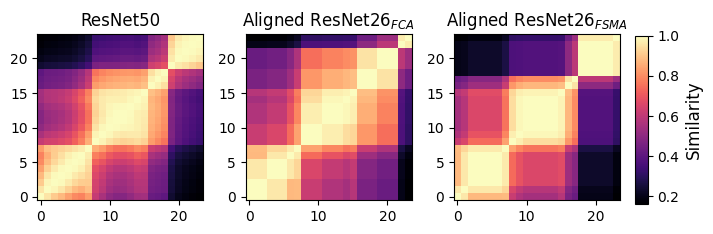

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3)
save_path: str = "result_plots/compare2self.pdf"

def add_colorbar(im, aspect=10, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def plot_results(ax,matrix, title: str = None, colorbar=False):
        im = ax.imshow(matrix, origin='lower', cmap='magma')
        if title is not None:
            ax.set_title(f"{title}", fontsize=12)
        return im

plot_results(ax[0],mat_normal, "ResNet50")
plot_results(ax[1],mat_sma, "Aligned ResNet26$_{SMA}$")
im = plot_results(ax[2],mat_lma, "Aligned ResNet26$_{LMA}$")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.32, 0.02, 0.35])
cbar_ax.tick_params(labelsize=10)
cbar =fig.colorbar(im, shrink=1.0,cax=cbar_ax)
cbar.set_label('Similarity', fontsize=12)


plt.tight_layout()

if save_path is not None:
    fig.savefig(save_path,bbox_inches='tight')

plt.show()

/tmp/ipykernel_6457/4038392740.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


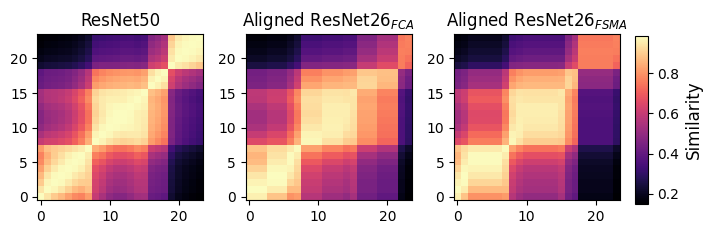

In [ ]:
fig, ax = plt.subplots(1,3)
save_path: str = "result_plots/compare2origin.pdf"

plot_results(ax[0],mat_normal, "ResNet50")
plot_results(ax[1],mat_sma2, "Aligned ResNet26$_{SMA}$")
im = plot_results(ax[2],mat_lma2, "Aligned ResNet26$_{LMA}$")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.32, 0.02, 0.35])
cbar_ax.tick_params(labelsize=10)
cbar =fig.colorbar(im, shrink=1.0,cax=cbar_ax)
cbar.set_label('Similarity', fontsize=12)


plt.tight_layout()

if save_path is not None:
    fig.savefig(save_path,bbox_inches='tight')

plt.show()